In [1]:
# split data in 3 folders in the ratio of 6:2:2


import splitfolders
input_folder = "Untouch_Dataset_1/Input_DataSet"
output = "Untouch_DataSet_1/Processed_Dataset"
splitfolders.ratio(input_folder, output, seed=42, ratio=(.6,.2,.2))

Copying files: 54462 files [04:46, 189.89 files/s]


In [2]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

In [3]:
img_height, img_width = (224,224)
batch_size = 32

train_data_dir = r"Untouch_DataSet_1\Processed_Dataset\train"
valid_data_dir = r"Untouch_DataSet_1\Processed_Dataset\val"
test_data_dir  = r"Untouch_DataSet_1\Processed_Dataset\test"

In [4]:
# Image Enhancement in ResNet50 through zoom,horizontal flip, shear
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range =0.2,
    zoom_range =0.2,
    horizontal_flip=True,
    validation_split=0.4)

#initialize the training generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height,img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='training') # Set as Training Data


#initialize the validate generator
valid_generator = train_datagen.flow_from_directory(
    valid_data_dir, # some directory as training data
    target_size = (img_height,img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation') #set as Validation

Found 26143 images belonging to 5 classes.
Found 6531 images belonging to 5 classes.


In [5]:
#initialize the test generator
test_generator = train_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height,img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='training') # Set as Test Data


Found 6541 images belonging to 5 classes.


In [6]:
x,y = test_generator.next()
x.shape

(32, 224, 224, 3)

In [7]:
base_model = ResNet50(include_top =False, weights='imagenet')
x= base_model.output
x= GlobalAveragePooling2D()(x)
x= Dense(1024,activation='relu')(x)
predictions = Dense(train_generator.num_classes,activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss ='categorical_crossentropy', metrics =['accuracy'])

r=model.fit(train_generator, 
          epochs = 5)


Epoch 1/5
817/817 [==============================] - 2653s 3s/step - loss: 0.0504 - accuracy: 0.9853
Epoch 2/5
817/817 [==============================] - 3075s 4s/step - loss: 0.0198 - accuracy: 0.9937
Epoch 3/5
817/817 [==============================] - 4035s 5s/step - loss: 0.0062 - accuracy: 0.9979
Epoch 4/5
817/817 [==============================] - 3960s 5s/step - loss: 0.0091 - accuracy: 0.9974
Epoch 5/5
817/817 [==============================] - 15361s 19s/step - loss: 0.0097 - accuracy: 0.9980


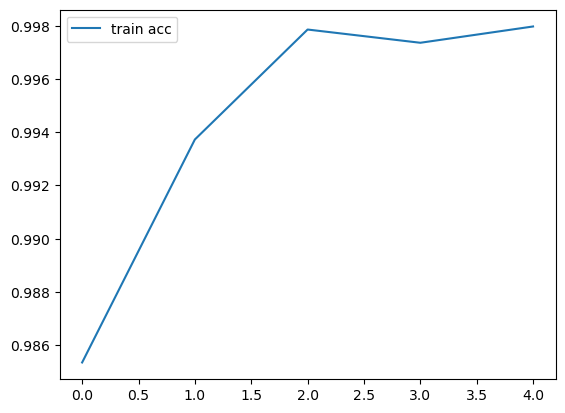

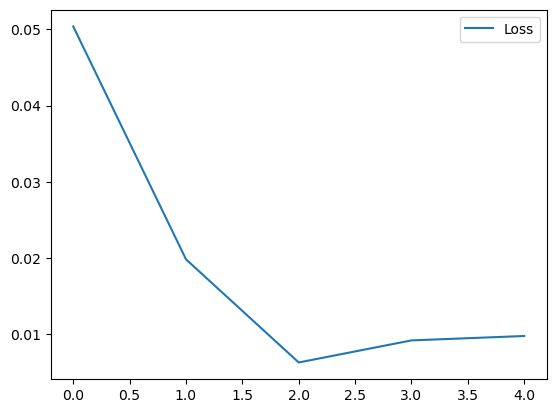

<Figure size 640x480 with 0 Axes>

In [9]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# plot the accuracy
plt.plot(r.history['loss'], label='Loss')
plt.legend()
plt.show()
plt.savefig('Loss Acc')

In [14]:
model.save('Untouch_DataSet_1\Saved_model1\ResNet50_PD_Apr09.h5')

In [29]:
from sklearn.metrics import classification_report

Y_pred = model.predict(train_generator)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(train_generator.classes, y_pred))

817/817 [==============================] - 2313s 3s/step
              precision    recall  f1-score   support

           0       0.12      0.12      0.12      3201
           1       0.23      0.23      0.23      5933
           2       0.20      0.20      0.20      5502
           3       0.31      0.31      0.31      8228
           4       0.13      0.13      0.13      3279

    accuracy                           0.22     26143
   macro avg       0.20      0.20      0.20     26143
weighted avg       0.22      0.22      0.22     26143



Confusion matrix, without normalization
[[6 0]
 [0 2]]


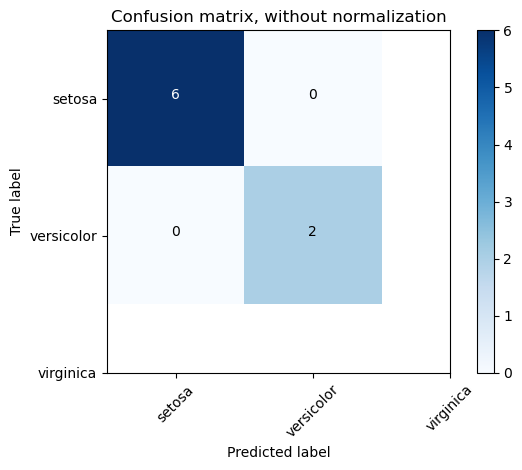

In [17]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45, test_size=0.05)
    

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear')
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [12]:
conda --version

conda 22.11.1

Note: you may need to restart the kernel to use updated packages.


In [16]:
# applying for the actual dataset

import tensorflow_datasets as tfds
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import resource

from absl import logging
import tensorflow_datasets.core.logging as _tfds_logging
from tensorflow_datasets.core.logging import call_metadata as _call_metadata


data, info = tfds.load('iris', split='train',
                       as_supervised=True,
                       shuffle_files=True,
                       with_info=True)

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_generator = data.take(120).batch(4).prefetch(buffer_size=AUTOTUNE)
test_generator = data.skip(120).take(30).batch(4).prefetch(buffer_size=AUTOTUNE)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(info.features['label'].num_classes, activation='softmax')
    ])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
              metrics='accuracy')

history = model.fit(train_dataset, validation_data=test_dataset, epochs=50, verbose=0)

y_pred = model.predict(test_dataset)

predicted_categories = tf.argmax(y_pred, axis=1)

true_categories = tf.concat([y for x, y in test_dataset], axis=0)

confusion_matrix(predicted_categories, true_categories)

ImportError: cannot import name 'core' from partially initialized module 'tensorflow_datasets' (most likely due to a circular import) (C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\tensorflow_datasets\__init__.py)